False
True
fitness                False
Volume                 False
MolWt                  False
NumHeavyAtoms          False
Hydropathy             False
NumRotatableBonds      False
FractionCSP3           False
Acceptor               False
Donor                  False
Aromatic               False
Hydrophobe             False
LumpedHydrophobe       False
NetCharge              False
Charge                 False
NumPolarRes            False
NumApolarRes           False
NumChargedRes          False
ProtRDF_all_2.0_3.0    False
ProtRDF_all_3.0_4.0    False
ProtRDF_all_4.0_5.0    False
RosettaEnergy          False
loss                   False
dtype: bool


,id,mut_id,fitness,Volume,MolWt,NumHeavyAtoms,Hydropathy,NumRotatableBonds,FractionCSP3,Acceptor,...,NetCharge,Charge,NumPolarRes,NumApolarRes,NumChargedRes,ProtRDF_all_2.0_3.0,ProtRDF_all_3.0_4.0,ProtRDF_all_4.0_5.0,RosettaEnergy,loss
1261,W41C:0.0,W41C,0.0,-119.3,-83.068,-8,3.4,-1,0.484848,0,...,0,8,14,28,16,-36,-171,-342,-3.621,0.170392


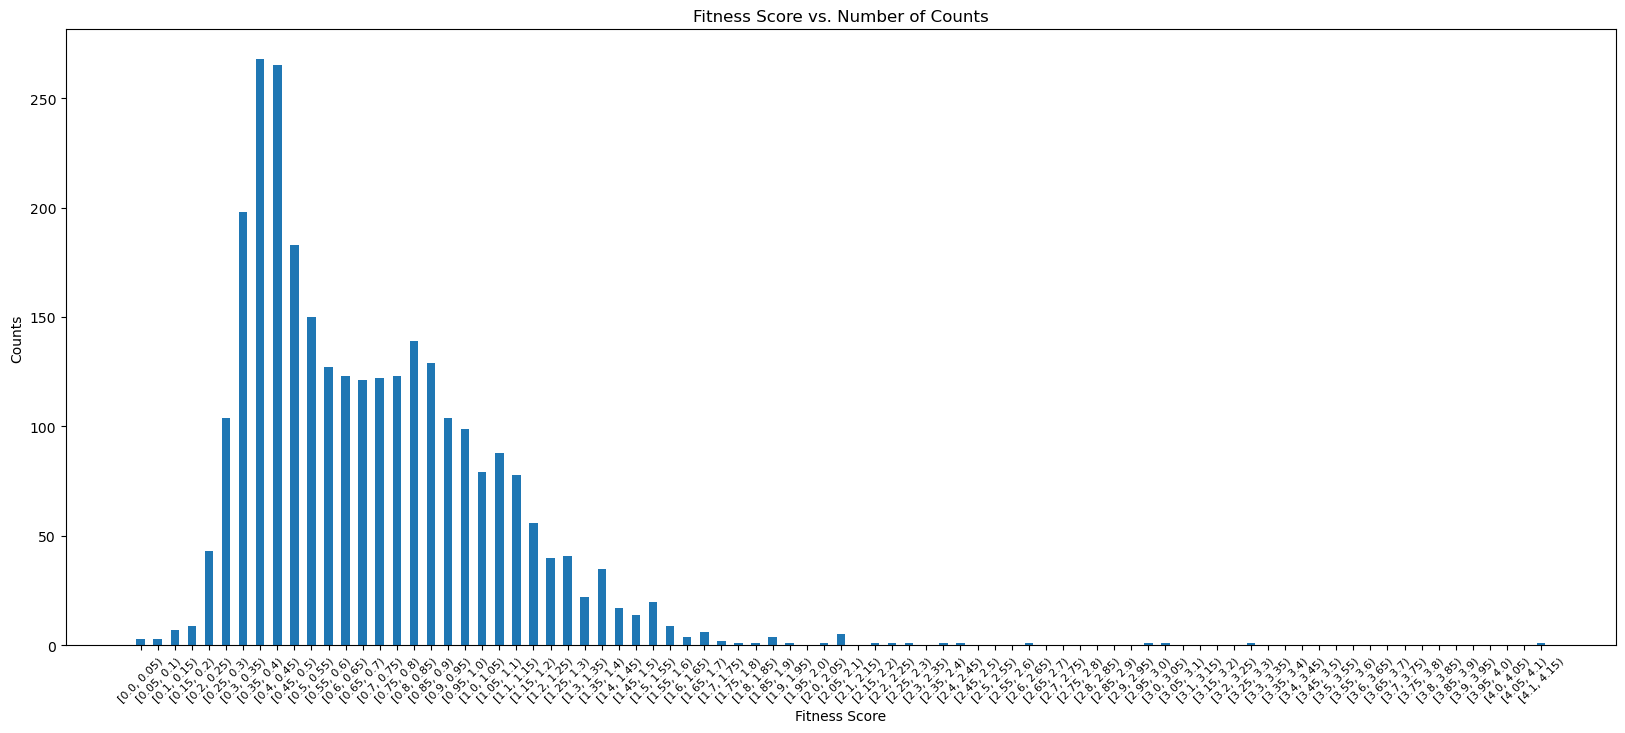

In [1]:
# Import all needed libraries for this notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.linear_model import RidgeCV

# Import features.csv and split the 'id' column into 'id' and 'fitness' columns, keeping the original
features = pd.read_csv("features.csv")
features[['mut_id', 'fitness']] = features['id'].str.split(':', expand=True)
features = features[['id', 'mut_id', 'fitness'] + [col for col in features.columns if col not in ['id', 'mut_id', 'fitness']]]
features['fitness'] = pd.to_numeric(features['fitness'])

# Inspect the data for any zero, infinite or NaN values, especially in the 'fitness' column
print(features.isna().any().any())
print((features['fitness'] == 0).any())
features_numeric = features.select_dtypes(include=[np.number])
print(np.isinf(features_numeric).any())

# Identify the locations where 'fitness' is 0
zero_fitness_locations = features[features['fitness'] == 0]
#print("Rows where 'fitness' is 0:")
display(zero_fitness_locations) # Just one value - leave

# Bin fitness scores in 0.05 bins
#fitness_counts = features['fitness'].value_counts().sort_index()
bin_edges = np.arange(features['fitness'].min(), features['fitness'].max() + 0.05, 0.05)
features['fitness_binned'] = pd.cut(features['fitness'], bins=bin_edges, right=False)
binned_counts = features['fitness_binned'].value_counts().sort_index()

# Plot the fitness score against the number of counts
plt.figure(figsize=(20, 8))
plt.bar(binned_counts.index.astype(str), binned_counts.values, width=0.5, align='center')
plt.xlabel('Fitness Score')
plt.ylabel('Counts')
plt.title('Fitness Score vs. Number of Counts')
plt.xticks(rotation=45, fontsize=8)
plt.show()

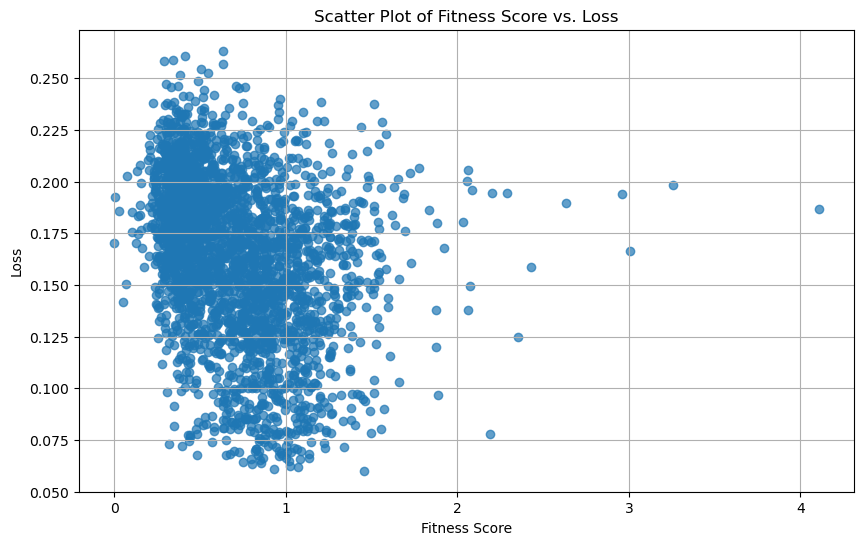

Spearman correlation: -0.3906344323875879, p-value: 1.0947715485300501e-104


In [2]:
# Plot 'fitness' score against 'loss' and calculate Spearman's correlation

plt.figure(figsize=(10, 6))
plt.scatter(features['fitness'], features['loss'], alpha=0.7)
plt.xlabel('Fitness Score')
plt.ylabel('Loss')
plt.title('Scatter Plot of Fitness Score vs. Loss')
plt.grid(True)
plt.show()

# Calculate Spearman correlation
spearman_corr, spearman_p_value = spearmanr(features['fitness'], features['loss'])
print(f"Spearman correlation: {spearman_corr}, p-value: {spearman_p_value}")

In [3]:
# Bin fitness scores by quantiles
quantile_no = 8
features['fitness_group'], bins = pd.qcut(features['fitness'], q=quantile_no, labels=False, retbins=True)

# Print bin edges
print("Bin edges (boundaries):", bins)
display(features)

Bin edges (boundaries): [0.         0.34742916 0.41501102 0.49650659 0.62802055 0.77240558
 0.9084807  1.10469232 4.10751009]


,id,mut_id,fitness,Volume,MolWt,NumHeavyAtoms,Hydropathy,NumRotatableBonds,FractionCSP3,Acceptor,...,NumPolarRes,NumApolarRes,NumChargedRes,ProtRDF_all_2.0_3.0,ProtRDF_all_3.0_4.0,ProtRDF_all_4.0_5.0,RosettaEnergy,loss,fitness_binned,fitness_group
0,K30D:0.5080366134643555,K30D,0.508037,-57.5,-13.087,-1,0.4,-2,-0.333333,2,...,6,9,3,1,-11,-20,-11.954,0.181988,"[0.5, 0.55)",3
1,D127S:0.619499683380127,D127S,0.619500,-22.1,-28.010,-2,2.7,-1,0.166667,-1,...,13,14,5,-1,-12,8,-1.321,0.117051,"[0.6, 0.65)",3
2,L114Y:0.9718983173370361,L114Y,0.971898,26.9,50.016,4,-5.1,0,-0.611111,1,...,10,29,7,-5,-16,-51,3.378,0.172539,"[0.95, 1.0)",6
3,H83F:0.5161952972412109,H83F,0.516195,36.7,10.035,1,6.0,0,-0.111111,-1,...,19,31,12,8,24,48,33.264,0.211969,"[0.5, 0.55)",3
4,R61G:0.7325457334518433,R61G,0.732546,-113.3,-99.137,-7,4.1,-4,-0.166667,-1,...,9,32,7,-21,-72,-171,-6.110,0.151326,"[0.7, 0.75)",4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2849,A15W:0.6964787244796753,A15W,0.696479,139.2,115.135,9,-2.7,2,-0.484848,0,...,8,13,8,9,67,168,-13.282,0.207076,"[0.65, 0.7)",4
2850,P28F:0.5048689246177673,P28F,0.504869,77.2,50.060,4,4.4,2,-0.577778,0,...,11,20,8,-1,13,55,-6.672,0.173218,"[0.5, 0.55)",3
2851,I112Y:0.28946661949157715,I112Y,0.289467,26.9,50.016,4,-5.8,0,-0.611111,1,...,14,31,11,17,21,6,111.471,0.174368,"[0.25, 0.3)",0
2852,P32W:0.9419150352478027,P32W,0.941915,115.1,89.097,7,0.7,2,-0.618182,0,...,5,4,3,-8,23,56,-13.450,0.201536,"[0.9, 0.95)",6


In [4]:
### Using biophysical features, train a Random Forest Regressor (rfr). Use stratified sampling
# Split the data into features (X) and target (y)
X = features.drop(columns=['mut_id', 'fitness', 'loss', 'fitness_binned'])
y = features['fitness']

# Use train_test_split with the stratify parameter
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=96, stratify=X['fitness_group'], random_state=42)

display(X_train)

# Train the rfr
rfr = RandomForestRegressor(random_state=42)
rfr.fit(X_train.drop(columns=['id', 'fitness_group']), y_train)

# Predict the fitness scores for the test set
y_pred = rfr.predict(X_test.drop(columns=['id', 'fitness_group']))

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
r2 = r2_score(y_test, y_pred)
print(f"R2 score: {r2}")
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

# Spearman's correl
spearman_corr, spearman_p_value = spearmanr(y_test, y_pred)
print(f"Spearman's correlation: {spearman_corr}")
print(f"Spearman's p-value: {spearman_p_value}")

,id,Volume,MolWt,NumHeavyAtoms,Hydropathy,NumRotatableBonds,FractionCSP3,Acceptor,Donor,Aromatic,...,NetCharge,Charge,NumPolarRes,NumApolarRes,NumChargedRes,ProtRDF_all_2.0_3.0,ProtRDF_all_3.0_4.0,ProtRDF_all_4.0_5.0,RosettaEnergy,fitness_group
743,F77S:0.34993505477905273,-100.9,-60.099,-5,-3.6,-1,0.444444,1,1,-1,...,0,1,16,37,9,-33,-110,-230,-2.958,1
1451,P73N:0.37244078516960144,1.4,16.987,1,-1.9,2,-0.300000,1,1,0,...,0,1,13,26,15,5,-12,17,1.595,1
2247,L57Q:0.9007079005241394,-22.9,14.971,1,-7.3,1,-0.233333,1,1,0,...,0,4,7,29,10,-11,-32,-22,-11.100,5
2281,D102W:0.8114498257637024,116.7,71.126,6,2.6,0,-0.318182,-2,1,2,...,1,-2,9,12,6,3,19,35,-7.367,5
544,T29G:0.9752710461616516,-56.0,-44.053,-3,0.3,-1,-0.250000,-1,-1,0,...,0,1,6,16,7,-13,-62,-127,-11.643,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025,F77H:0.3387545049190521,-36.7,-10.035,-1,-6.0,0,0.111111,1,1,0,...,0,1,16,37,9,-17,-35,-56,-8.135,0
2500,L94N:0.44525304436683655,-52.6,0.944,0,-7.3,0,-0.333333,1,1,0,...,0,-2,14,27,12,-5,-56,-98,-12.894,2
480,L38F:0.8292379379272461,23.2,34.017,3,-1.0,0,-0.611111,0,0,1,...,0,4,12,20,12,-7,-21,-4,-11.468,5
1174,A156F:0.8652383685112,101.3,76.098,6,1.0,2,-0.444444,0,0,1,...,0,3,2,17,5,12,31,69,-9.789,5


Mean Squared Error: 0.11146391119795329
R2 score: 0.11593108411766062
Mean Absolute Error: 0.25011037513365847
Spearman's correlation: 0.3899268577256304
Spearman's p-value: 7.745930691999177e-101


In [5]:
# Select most important RFR features
# Extracting the coefficients 
importances = rfr.feature_importances_
importances.shape

# Create a dataframe to store features and their importance
feature_importances_rfr_df = pd.DataFrame({
    'Feature': X.drop(columns=['id', 'fitness_group']).columns,
    'Importance': importances
})

# Ranking features based on the absolute values of their coefficients
feature_importances_rfr_df = feature_importances_rfr_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)
feature_importances_rfr_df

,Feature,Importance
0,FractionCSP3,0.135849
1,NumPolarRes,0.135077
2,RosettaEnergy,0.122560
3,NumApolarRes,0.101571
4,MolWt,0.072606
5,Hydropathy,0.062381
6,Charge,0.059571
7,Volume,0.050201
8,ProtRDF_all_2.0_3.0,0.039083
9,ProtRDF_all_3.0_4.0,0.036904


Mean Squared Error: 0.11064962646192443
R2 score: 0.12238953166416822
Mean Absolute Error: 0.2483384562511824
Spearman's correlation: 0.40105017514847796
Spearman's p-value: 4.31476508988072e-107


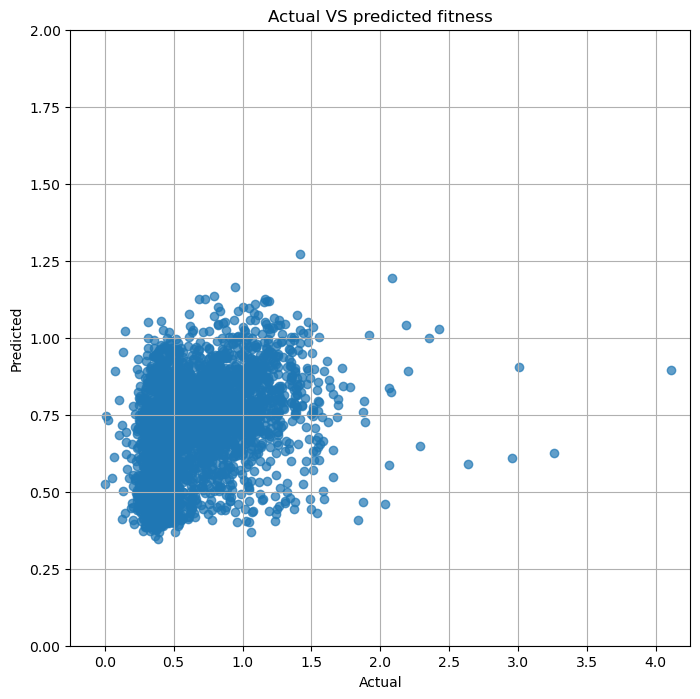

In [6]:
# Select top 11 biophysical features (highest Spearman's correl)
X_train2 = X_train.drop(columns=['Aromatic', 'NetCharge', 'LumpedHydrophobe', 'Donor', 'NumHeavyAtoms', 'Acceptor', 'NumChargedRes', 'Hydrophobe', 'ProtRDF_all_4.0_5.0'])
X_test2 = X_test.drop(columns=['Aromatic', 'NetCharge', 'LumpedHydrophobe', 'Donor', 'NumHeavyAtoms', 'Acceptor', 'NumChargedRes', 'Hydrophobe', 'ProtRDF_all_4.0_5.0'])

# Re-train rfr
rfr2 = RandomForestRegressor(random_state=42)
rfr2.fit(X_train2.drop(columns=['id', 'fitness_group']), y_train)

# Predict the fitness scores for the test set
y_pred2 = rfr2.predict(X_test2.drop(columns=['id', 'fitness_group']))

# Evaluate the model
mse = mean_squared_error(y_test, y_pred2)
print(f"Mean Squared Error: {mse}")
r2 = r2_score(y_test, y_pred2)
print(f"R2 score: {r2}")
mae = mean_absolute_error(y_test, y_pred2)
print(f"Mean Absolute Error: {mae}")

# Spearman's correl
spearman_corr, spearman_p_value = spearmanr(y_test, y_pred2)
print(f"Spearman's correlation: {spearman_corr}")
print(f"Spearman's p-value: {spearman_p_value}")

# Plot actual fitness against predicted
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred2, alpha=0.7)
plt.xlim(-0.25, 4.25)
plt.ylim(0, 2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual VS predicted fitness')
plt.grid(True)
plt.show()

Best alpha: 100.0
Training Score: 0.32672827209722455
Test Score: 0.11171069937521971
Mean Squared Error: 0.11199601970409064
R2 score: 0.11171069937521971
Mean Absolute Error: 0.2519570315155791
Spearman's correlation: 0.394491708479928
Spearman's p-value: 2.2465882601770913e-103


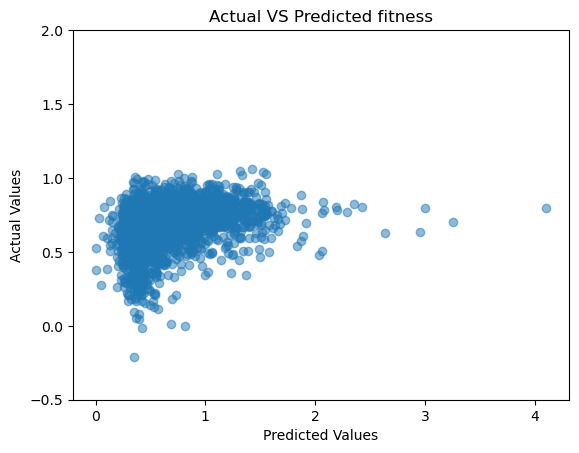

In [7]:
# Ridge regression on top 11 biophysical features

# Drop bottom features as determined by RFR
### NB: previous X, y, X_train, X_test, y_train, y_test variables will be overwritten ###
X = features.drop(columns=['mut_id', 'loss', 'fitness_binned', 'fitness', 'Aromatic', 'NetCharge', 'LumpedHydrophobe', 'Donor', 'NumHeavyAtoms', 'Acceptor', 'NumChargedRes', 'Hydrophobe', 'ProtRDF_all_4.0_5.0']) #Still contains 'id' and 'fitness_group'columns
y = features['fitness']

poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X.drop(columns=['id', 'fitness_group']))

# Scale
minmaxscaler = MinMaxScaler()
scaler = StandardScaler()
X_poly_norm = scaler.fit_transform(X_poly)
X_poly_minmax = minmaxscaler.fit_transform(X_poly)

# Sample 96 samples, in a stratified manner, based on fitness_group
X_train, X_test, y_train, y_test = train_test_split(X_poly_norm, y, train_size=96, stratify=X['fitness_group'], random_state=42)

# Define a range of alphas for cross-validation
alphas = np.logspace(-6, 6, 13)  
ridge_cv_poly = RidgeCV(alphas=alphas, store_cv_values=True)
ridge_cv_poly.fit(X_train, y_train)

# Predict the fitness for the test set
y_pred_ridge_poly = ridge_cv_poly.predict(X_test)

# Print the best alpha and model performance
print(f"Best alpha: {ridge_cv_poly.alpha_}")
print(f"Training Score: {ridge_cv_poly.score(X_train, y_train)}")
print(f"Test Score: {ridge_cv_poly.score(X_test, y_test)}")

# Predict and evaluate the model
mse = mean_squared_error(y_test, y_pred_ridge_poly)
print(f"Mean Squared Error: {mse}")
r2 = r2_score(y_test, y_pred_ridge_poly)
print(f"R2 score: {r2}")
mae = mean_absolute_error(y_test, y_pred_ridge_poly)
print(f"Mean Absolute Error: {mae}")
# Spearman's correl
spearman_corr, spearman_p_value = spearmanr(y_test, y_pred_ridge_poly)
print(f"Spearman's correlation: {spearman_corr}")
print(f"Spearman's p-value: {spearman_p_value}")

# Plot predicted VS actal fitness
plt.scatter(y_test, y_pred_ridge_poly, alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylim(-0.5, 2)
plt.ylabel('Actual Values')
plt.title('Actual VS Predicted fitness')
plt.show()